In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import yfinance as yf
import time
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

# Preliminary Step 1: Obtain S&P500 stock tickers from wikipedia

In [2]:
def pull_sp500(url):
    response = requests.get(url)  # grab the response
    soup = BeautifulSoup(response.content, 'html.parser')  # create html parser 
    ticker_html = soup.find_all(id='constituents')[0]  # all table data is under 'constituents' id per wiki source
    rows = ticker_html.find_all('tr')  # pull all rows from the table html
    header = rows.pop(0).text.split('\n')  # get the header as a list
    header = [i for i in header if i != '']  # skip blanks
    keep_idx = [0, 1, 3, 4]  # column numbers we want to keep
    ticker_data = []
    for row in rows:
        data = row.text.split('\n')
        data = [i for i in data if i != '']
        record = {header[i]: data[i] for i in keep_idx}
        ticker_data.append(record)
    return ticker_data

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
ticker_info_path = os.path.normpath('data/sp500_ticker_info.csv')


#  check if we have the ticker info saved, if not, pull and save it
if not (os.path.isfile(ticker_info_path) and os.access(ticker_info_path, os.R_OK)):
    ticker_info = pull_sp500(url)
    ticker_info_df = pd.DataFrame(ticker_info)
    ticker_info_df.to_csv(ticker_info_path, index=False)
else:
    ticker_info_df = pd.read_csv(ticker_info_path)

ticker_info_df.head()

,Symbol,Security,GICS Sector,GICS Sub Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services


# Preliminary Step 2: Pull ticker data for each symbol using yfinance

In [4]:
def download_ticker_data(symbols, start_date, end_date):
    all_data = []
    for symbol in tqdm(symbols):
        symbol = symbol.replace('.', '-')  # yahoo finance uses dashes not dots in symbols
        ticker_data = yf.download(symbol, start=start_date, end=end_date).reset_index()
        ticker_data['Symbol'] = len(ticker_data) * [symbol]
        all_data.append(ticker_data)
        time.sleep(5)  # avoid spamming yahoo
    return pd.concat(all_data, axis='rows', ignore_index=True)

In [5]:
start_date = '2020-01-01'
end_date = '2020-08-28'

ticker_price_path = os.path.normpath('data/sp500_ticker_prices.csv')

if not (os.path.isfile(ticker_price_path) and os.access(ticker_price_path, os.R_OK)):
    ticker_price_df = download_ticker_data(ticker_info_df['Symbol'], start_date, end_date)
    ticker_price_df.to_csv(ticker_price_path, index=False)
else:
    ticker_price_df = pd.read_csv(ticker_price_path)

In [6]:
ticker_price_df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2020-01-02,177.679993,180.009995,177.139999,180.000000,175.039474,3601700.0,MMM
1,2020-01-03,177.020004,178.660004,175.630005,178.449997,173.532181,2466900.0,MMM
2,2020-01-06,177.149994,178.710007,176.350006,178.619995,173.697495,1998000.0,MMM
3,2020-01-07,178.279999,178.509995,176.820007,177.899994,172.997330,2173000.0,MMM
4,2020-01-08,178.000000,181.500000,177.649994,180.630005,175.652115,2758300.0,MMM
5,2020-01-09,181.509995,181.589996,179.759995,181.199997,176.206390,2746300.0,MMM
6,2020-01-10,181.610001,182.179993,180.139999,180.470001,175.496521,2103800.0,MMM
7,2020-01-13,180.940002,182.229996,180.360001,180.919998,175.934097,2090800.0,MMM
8,2020-01-14,180.919998,182.550003,180.210007,181.369995,176.371719,2911200.0,MMM
9,2020-01-15,181.419998,181.860001,179.179993,179.779999,174.825516,2482200.0,MMM


# Research Question 1
In this section, we wanted to find out due to the COVID19 Market Crash on March 16, 2020:
- Which stocks were affected the most?
- Which industries were affected the most/least?

In [7]:
## Code for Research Question 1 here ##

#merge dataframes
merged_stocks = pd.merge(ticker_info_df, ticker_price_df, how="inner", on="Symbol")
merged_stocks.head()

merged_stocks.dropna(inplace=True)
merged_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83357 entries, 0 to 83367
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             83357 non-null  object 
 1   Security           83357 non-null  object 
 2   GICS Sector        83357 non-null  object 
 3   GICS Sub Industry  83357 non-null  object 
 4   Date               83357 non-null  object 
 5   Open               83357 non-null  float64
 6   High               83357 non-null  float64
 7   Low                83357 non-null  float64
 8   Close              83357 non-null  float64
 9   Adj Close          83357 non-null  float64
 10  Volume             83357 non-null  float64
dtypes: float64(6), object(5)
memory usage: 7.6+ MB


In [8]:
#Which stocks had the greatest negative % change in value? Positive % change in value?  

#convert "Date" column from object to datetime
merged_stocks["Date"] = pd.to_datetime(merged_stocks["Date"])
merged_stocks.info()

#selecting our timeframe
start_date = "2020-01-02" 
end_date = "2020-03-16"
mask = (merged_stocks['Date'] >= start_date) & (merged_stocks['Date'] <= end_date)
narrowed_times_df = merged_stocks.loc[mask]
narrowed_times_df["GICS Sector"].value_counts()
print(type(mask))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83357 entries, 0 to 83367
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Symbol             83357 non-null  object        
 1   Security           83357 non-null  object        
 2   GICS Sector        83357 non-null  object        
 3   GICS Sub Industry  83357 non-null  object        
 4   Date               83357 non-null  datetime64[ns]
 5   Open               83357 non-null  float64       
 6   High               83357 non-null  float64       
 7   Low                83357 non-null  float64       
 8   Close              83357 non-null  float64       
 9   Adj Close          83357 non-null  float64       
 10  Volume             83357 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 7.6+ MB
<class 'pandas.core.series.Series'>


In [9]:
percent_changes_list = []
symbols_list = narrowed_times_df['Symbol'].unique()

#loop through each symbol 

for symbol in symbols_list:
    looped_symbols_df = narrowed_times_df.loc[narrowed_times_df['Symbol'] == symbol].sort_values(by="Date")
    security_name = looped_symbols_df.iloc[0,1]
    sector_name = looped_symbols_df.iloc[0,2]
    open_first = looped_symbols_df.iloc[0,5]
    close_last = looped_symbols_df.iloc[-1, 8]
    percent_changes = ((close_last - open_first)/open_first)*100

    percent_change_df = pd.DataFrame({"Ticker": symbol, "Security Name": security_name, "Percent Change": percent_changes, "Industry": sector_name}, index=[0])

    percent_changes_list.append(percent_change_df)

master_stocks_df = pd.concat(percent_changes_list, axis="rows", ignore_index=True, sort=False)

sorted_stocks_df = master_stocks_df.sort_values(by="Percent Change")

stock_winners_df = sorted_stocks_df.tail(10)
stock_winners_df.to_csv("data/stock_winners_rq1.csv")
print(stock_winners_df)
stock_losers_df = sorted_stocks_df.head(10)
stock_losers_df.to_csv("data/stock_losers_rq1.csv")
print(stock_losers_df)
master_stocks_df

    Ticker              Security Name  Percent Change                Industry
480    WEC           WEC Energy Group        0.303029               Utilities
259   JKHY    Jack Henry & Associates        1.017277  Information Technology
262    SJM                 JM Smucker        3.562853        Consumer Staples
212   GILD            Gilead Sciences        5.142687             Health Care
405   SBAC         SBA Communications        6.452415             Real Estate
142    DLR   Digital Realty Trust Inc        6.916086             Real Estate
277     KR                 Kroger Co.        7.130553        Consumer Staples
399    ROL               Rollins Inc.        7.551138             Industrials
109    CLX         The Clorox Company       13.893596        Consumer Staples
393   REGN  Regeneron Pharmaceuticals       16.621690             Health Care
    Ticker                   Security Name  Percent Change  \
345   NCLH  Norwegian Cruise Line Holdings      -81.391394   
340    NBL        

,Ticker,Security Name,Percent Change,Industry
0,MMM,3M Company,-26.322597,Industrials
1,ABT,Abbott Laboratories,-14.408545,Health Care
2,ABBV,AbbVie Inc.,-16.625511,Health Care
3,ABMD,ABIOMED Inc,-17.430870,Health Care
4,ACN,Accenture plc,-27.658165,Information Technology
...,...,...,...,...
496,YUM,Yum! Brands Inc,-30.792863,Consumer Discretionary
497,ZBRA,Zebra Technologies,-35.883873,Information Technology
498,ZBH,Zimmer Biomet Holdings,-38.658486,Health Care
499,ZION,Zions Bancorp,-49.274257,Financials


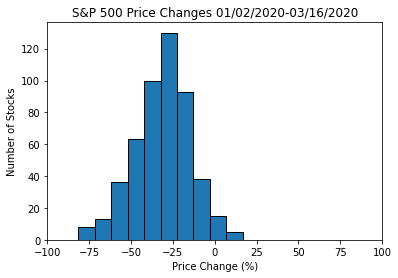

In [10]:
#frequency of stock price changes 
sorted_stocks_df.plot(kind="hist", legend=False, xlim=[-100,100],edgecolor='k')

plt.title("S&P 500 Price Changes 01/02/2020-03/16/2020")
plt.xlabel("Price Change (%)")
plt.ylabel("Number of Stocks")

plt.show()

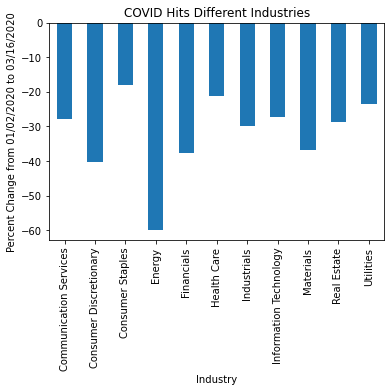

<class 'pandas.core.series.Series'>


In [11]:
#see which industries suffered the most

grouped_stocks_df = master_stocks_df.groupby(by="Industry")
grouped_stocks_averages = grouped_stocks_df["Percent Change"].mean()
grouped_stocks_averages.plot(kind="bar")
plt.title("COVID Hits Different Industries")
plt.ylabel("Percent Change from 01/02/2020 to 03/16/2020")
plt.show()

print(type(grouped_stocks_averages))

# Research Question 2

Which of the preceding stocks appear to have recovered the most?

Using March as a starting point, we noticed that regardless of what each of the 5 companies were in business to do, all of them experienced a negative percent change in Price.

Things turned around in the following month of April. As you can see in the bar graph below, APA, had the most significant recovery. In March they went from a percentage change of -83% to 1.75% in April. This company specilizes in engaged in hydrocarbon exploration.

Looking at another comapany that experienced recovery but less significant compared to APA was KSS -62% to 43%.

We belive April was the month that the first round of stimulus checks were being distributed to Americans throughout the contry. There could be several reasons why these companies were able to recover in this time period, our recommendation would be to look at these months in particular to see what happened because it helped their businesses recover during a pandemic.

In [12]:
#Change the Data field to the datetime type
ticker_price_df["Date"] = pd.to_datetime(ticker_price_df.Date)

In [13]:
# Display March Tickers for the begining of the month
March_Start = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-03-02'])]
March_Narrowed_Start = March_Start[["Date","Symbol","Open"]]
March_Narrowed_Start.head()

,Date,Symbol,Open
40,2020-03-02,MMM,151.339996
206,2020-03-02,ABT,77.879997
372,2020-03-02,ABBV,86.000000
538,2020-03-02,ABMD,151.089996
704,2020-03-02,ACN,182.000000


In [14]:
# Display April Tickers for the begining of the month
April_Start = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-04-02'])]
April_Narrowed_Start = April_Start[["Date","Symbol","Open"]]
April_Narrowed_Start.head()

,Date,Symbol,Open
63,2020-04-02,MMM,132.360001
229,2020-04-02,ABT,76.120003
395,2020-04-02,ABBV,72.779999
561,2020-04-02,ABMD,143.110001
727,2020-04-02,ACN,154.050003


In [15]:
# Display May Tickers for the begining of the month
May_Start = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-05-04'])]
May_Narrowed_Start = May_Start[["Date","Symbol","Open"]]
May_Narrowed_Start.head()

,Date,Symbol,Open
84,2020-05-04,MMM,148.539993
250,2020-05-04,ABT,89.790001
416,2020-05-04,ABBV,82.220001
582,2020-05-04,ABMD,182.580002
748,2020-05-04,ACN,177.979996


In [16]:
# Display March Tickers for the END of the month
March_End = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-03-31'])]
March_Narrowed_End = March_End[["Date","Symbol","Close"]]
March_Narrowed_End.head()

,Date,Symbol,Close
61,2020-03-31,MMM,136.509995
227,2020-03-31,ABT,78.910004
393,2020-03-31,ABBV,76.190002
559,2020-03-31,ABMD,145.160004
725,2020-03-31,ACN,163.259995


In [17]:
# Display April Tickers for the END of the month
April_End = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-04-30'])]
April_Narrowed_End = April_End[["Date","Symbol","Close"]]
April_Narrowed_End.head()

,Date,Symbol,Close
82,2020-04-30,MMM,151.919998
248,2020-04-30,ABT,92.089996
414,2020-04-30,ABBV,82.199997
580,2020-04-30,ABMD,191.250000
746,2020-04-30,ACN,185.190002


In [18]:
# Display May Tickers for the END of the month
May_End = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-05-29'])]
May_Narrowed_End = May_End[["Date","Symbol","Close"]]
May_Narrowed_End.head()

,Date,Symbol,Close
102,2020-05-29,MMM,156.440002
268,2020-05-29,ABT,94.919998
434,2020-05-29,ABBV,92.669998
600,2020-05-29,ABMD,223.899994
766,2020-05-29,ACN,201.619995


In [19]:
# Merge the March start date dataframe with the March end date dataframe
Table = pd.merge(March_Narrowed_Start,March_Narrowed_End,on='Symbol',how='left')
Table.head()

,Date_x,Symbol,Open,Date_y,Close
0,2020-03-02,MMM,151.339996,2020-03-31,136.509995
1,2020-03-02,ABT,77.879997,2020-03-31,78.910004
2,2020-03-02,ABBV,86.000000,2020-03-31,76.190002
3,2020-03-02,ABMD,151.089996,2020-03-31,145.160004
4,2020-03-02,ACN,182.000000,2020-03-31,163.259995


In [20]:
# Merge the April start date dataframe with the April end date dataframe
Table2 = pd.merge(April_Narrowed_Start,April_Narrowed_End,on='Symbol',how='left')
Table2.head()

,Date_x,Symbol,Open,Date_y,Close
0,2020-04-02,MMM,132.360001,2020-04-30,151.919998
1,2020-04-02,ABT,76.120003,2020-04-30,92.089996
2,2020-04-02,ABBV,72.779999,2020-04-30,82.199997
3,2020-04-02,ABMD,143.110001,2020-04-30,191.250000
4,2020-04-02,ACN,154.050003,2020-04-30,185.190002


In [21]:
# Merge the May start date dataframe with the May end date dataframe
Table3 = pd.merge(May_Narrowed_Start,May_Narrowed_End,on='Symbol',how='left')
Table3.head()

,Date_x,Symbol,Open,Date_y,Close
0,2020-05-04,MMM,148.539993,2020-05-29,156.440002
1,2020-05-04,ABT,89.790001,2020-05-29,94.919998
2,2020-05-04,ABBV,82.220001,2020-05-29,92.669998
3,2020-05-04,ABMD,182.580002,2020-05-29,223.899994
4,2020-05-04,ACN,177.979996,2020-05-29,201.619995


In [22]:
#Create a calculated column that subtracts the last close price for March from the first Open Price for March
Table['Percent Change March'] = (Table['Close'] - Table['Open'])/Table['Open']
Table.sort_values(by='Percent Change March', ascending=True).head()

,Date_x,Symbol,Open,Date_y,Close,Percent Change March
44,2020-03-02,APA,25.490000,2020-03-31,4.180000,-0.836014
346,2020-03-02,NCLH,37.099998,2020-03-31,10.960000,-0.704582
355,2020-03-02,OKE,67.650002,2020-03-31,21.809999,-0.677605
352,2020-03-02,OXY,33.580002,2020-03-31,11.580000,-0.655152
276,2020-03-02,KSS,39.200001,2020-03-31,14.590000,-0.627806


In [23]:
#Create a calculated column that subtracts the last close price for April from the first Open Price for April
Table2['Percent Change April'] = (Table2['Close'] - Table2['Open'])/Table2['Open']
Table2.sort_values(by='Percent Change April', ascending=True).head()

,Date_x,Symbol,Open,Date_y,Close,Percent Change April
106,2020-04-02,CINF,72.519997,2020-04-30,65.800003,-0.092664
183,2020-04-02,EXR,92.669998,2020-04-30,88.239998,-0.047804
385,2020-04-02,PSA,194.139999,2020-04-30,185.449997,-0.044762
179,2020-04-02,RE,180.729996,2020-04-30,173.130005,-0.042052
211,2020-04-02,GE,7.020000,2020-04-30,6.800000,-0.031339


In [24]:
#Create a calculated column that subtracts the last close price for May from the first Open Price for May
Table3['Percent Change May'] = (Table3['Close'] - Table3['Open'])/Table3['Open']
Table3.sort_values(by='Percent Change May', ascending=True).head()

,Date_x,Symbol,Open,Date_y,Close,Percent Change May
130,2020-05-04,COTY,5.030000,2020-05-29,3.630000,-0.278330
160,2020-05-04,DXC,16.500000,2020-05-29,14.210000,-0.138788
475,2020-05-04,VNO,41.009998,2020-05-29,36.209999,-0.117045
418,2020-05-04,SLG,47.700001,2020-05-29,42.119999,-0.116981
354,2020-05-04,OXY,14.370000,2020-05-29,12.950000,-0.098817


In [25]:
# Merge ALL dataframs for March/April/May
All_Tables = pd.merge(pd.merge(Table,Table2,on='Symbol'),Table3,on='Symbol')
All_Tables.head()

,Date_x_x,Symbol,Open_x,Date_y_x,Close_x,Percent Change March,Date_x_y,Open_y,Date_y_y,Close_y,Percent Change April,Date_x,Open,Date_y,Close,Percent Change May
0,2020-03-02,MMM,151.339996,2020-03-31,136.509995,-0.097991,2020-04-02,132.360001,2020-04-30,151.919998,0.147779,2020-05-04,148.539993,2020-05-29,156.440002,0.053184
1,2020-03-02,ABT,77.879997,2020-03-31,78.910004,0.013226,2020-04-02,76.120003,2020-04-30,92.089996,0.209800,2020-05-04,89.790001,2020-05-29,94.919998,0.057133
2,2020-03-02,ABBV,86.000000,2020-03-31,76.190002,-0.114070,2020-04-02,72.779999,2020-04-30,82.199997,0.129431,2020-05-04,82.220001,2020-05-29,92.669998,0.127098
3,2020-03-02,ABMD,151.089996,2020-03-31,145.160004,-0.039248,2020-04-02,143.110001,2020-04-30,191.250000,0.336385,2020-05-04,182.580002,2020-05-29,223.899994,0.226312
4,2020-03-02,ACN,182.000000,2020-03-31,163.259995,-0.102967,2020-04-02,154.050003,2020-04-30,185.190002,0.202142,2020-05-04,177.979996,2020-05-29,201.619995,0.132824


In [26]:
# Create a csv of the triple merged table above
Combined_Table_Path = os.path.normpath('data/AllTables.csv')
All_Tables.to_csv(Combined_Table_Path, index=False)

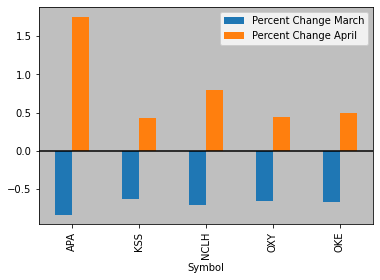

In [27]:
# Display Tickers that experienced a negative net price in March which was our starting point, but recoved in April with a positive net price
Tickers_Recovered = All_Tables.loc[All_Tables['Symbol'].isin(['APA','NCLH','OKE','OXY','KSS'])]
axis = Tickers_Recovered.plot(x ="Symbol", y=["Percent Change March","Percent Change April"], kind="bar")
axis.axhline(color='k')
axis.set_facecolor((0, 0, 0, 0.25))

# Research Question 3

## Which stocks were Negatively affected during the lockdown of covid-19? By Industry

- Data Analyzation done for all these stock from March to August 2020 using the sp500_ticker cvs files
- Which stocks still lag pre-COVID low - Example used June and July
- 2020 Summer!! Summer!! was a Bummer!!!

In [28]:
#merge dataframes
ticker_price_df["Date"] = pd.to_datetime(ticker_price_df.Date)
ticker_price_df.dtypes

#merge dataframes
merged_stocks = pd.merge(ticker_info_df, ticker_price_df, how="inner", on="Symbol")
merged_stocks.head()

merged_stocks.dropna(inplace=True)
merged_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83357 entries, 0 to 83367
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Symbol             83357 non-null  object        
 1   Security           83357 non-null  object        
 2   GICS Sector        83357 non-null  object        
 3   GICS Sub Industry  83357 non-null  object        
 4   Date               83357 non-null  datetime64[ns]
 5   Open               83357 non-null  float64       
 6   High               83357 non-null  float64       
 7   Low                83357 non-null  float64       
 8   Close              83357 non-null  float64       
 9   Adj Close          83357 non-null  float64       
 10  Volume             83357 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 7.6+ MB


In [29]:
#convert "Date" column from object to datetime
merged_stocks["Date"] = pd.to_datetime(merged_stocks["Date"])
merged_stocks.info()

#selecting our timeframe
start_date = "2020-03-16" 
end_date = "2020-08-28"
mask = (merged_stocks['Date'] >= start_date) & (merged_stocks['Date'] <= end_date)
narrowed_times_df = merged_stocks.loc[mask]
narrowed_times_df["GICS Sector"].value_counts()
print(type(mask))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83357 entries, 0 to 83367
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Symbol             83357 non-null  object        
 1   Security           83357 non-null  object        
 2   GICS Sector        83357 non-null  object        
 3   GICS Sub Industry  83357 non-null  object        
 4   Date               83357 non-null  datetime64[ns]
 5   Open               83357 non-null  float64       
 6   High               83357 non-null  float64       
 7   Low                83357 non-null  float64       
 8   Close              83357 non-null  float64       
 9   Adj Close          83357 non-null  float64       
 10  Volume             83357 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 7.6+ MB
<class 'pandas.core.series.Series'>


In [30]:
percent_changes_list = []
symbols_list = narrowed_times_df['Symbol'].unique()

#for loop through each symbol from

for symbol in symbols_list:
    looped_symbols_df = narrowed_times_df.loc[narrowed_times_df['Symbol'] == symbol].sort_values(by="Date")
    security_name = looped_symbols_df.iloc[0,1]
    sector_name = looped_symbols_df.iloc[0,2]
    open_first = looped_symbols_df.iloc[0,5]
    close_last = looped_symbols_df.iloc[-1, 8]
    percent_changes = ((close_last - open_first)/open_first)*100

    percent_change_df = pd.DataFrame({"Ticker": symbol, "Security Name": security_name, "Percent Change": percent_changes, "Industry": sector_name}, index=[0])
    percent_changes_list.append(percent_change_df)

master_stocks_df = pd.concat(percent_changes_list, axis="rows", ignore_index=True, sort=False)
sorted_stocks_df = master_stocks_df.sort_values(by="Percent Change")

stock_losers_df = sorted_stocks_df.head(10)
stock_losers_df.to_csv("data/stock_losers_rq3.csv")
print(stock_losers_df)
master_stocks_df

    Ticker                    Security Name  Percent Change          Industry
128   COTY                        Coty, Inc      -48.093844  Consumer Staples
190     FE                 FirstEnergy Corp      -25.464191         Utilities
394    REG      Regency Centers Corporation      -19.980311       Real Estate
416    SLG                  SL Green Realty      -18.754187       Real Estate
172    EQR               Equity Residential      -17.412861       Real Estate
73     BXP                Boston Properties      -16.943580       Real Estate
186    FRT  Federal Realty Investment Trust      -16.502560       Real Estate
451    UDR                        UDR, Inc.      -15.790741       Real Estate
414    SPG         Simon Property Group Inc      -14.338233       Real Estate
121     ED              Consolidated Edison      -14.010891         Utilities


,Ticker,Security Name,Percent Change,Industry
0,MMM,3M Company,26.351456,Industrials
1,ABT,Abbott Laboratories,57.522999,Health Care
2,ABBV,AbbVie Inc.,19.367092,Health Care
3,ABMD,ABIOMED Inc,135.449932,Health Care
4,ACN,Accenture plc,62.431726,Information Technology
...,...,...,...,...
498,YUM,Yum! Brands Inc,34.559556,Consumer Discretionary
499,ZBRA,Zebra Technologies,78.877426,Information Technology
500,ZBH,Zimmer Biomet Holdings,67.997605,Health Care
501,ZION,Zions Bancorp,28.582471,Financials


## Result
- Narrowing the Stocks, we got 10 Stock that did the worst during the lockdown
- Symbols ['COTY','SPG','EQR','WFC' 'FE', 'REG', 'BXP', 'FRT', 'UDR', 'ED']

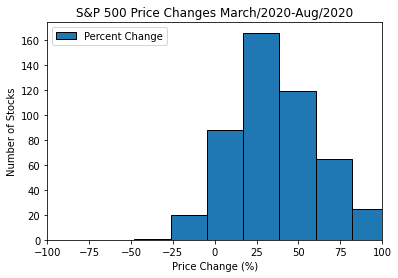

In [31]:
#frequency of stock price changes using Histogram
sorted_stocks_df.plot(kind="hist", legend=True, xlim=[-100,100],edgecolor='k')

plt.title("S&P 500 Price Changes March/2020-Aug/2020")
plt.xlabel("Price Change (%)")
plt.ylabel("Number of Stocks")

plt.show()

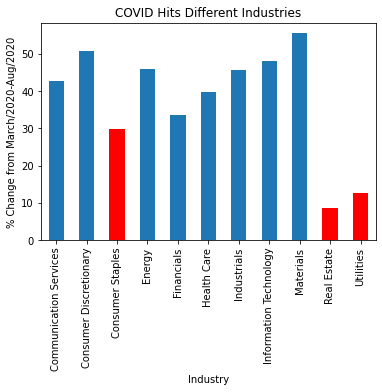

<class 'pandas.core.series.Series'>


In [32]:
grouped_stocks_df = master_stocks_df.groupby(by="Industry")
grouped_stocks_averages = grouped_stocks_df["Percent Change"].mean()
ax = grouped_stocks_averages.plot(kind="bar")
plt.title("COVID Hits Different Industries")
plt.ylabel("% Change from March/2020-Aug/2020")

bottom_3 = np.sort(grouped_stocks_averages)[:3]
for rect in ax.patches:
    height = rect.get_height()
    if np.isclose(height, bottom_3).any():
        rect.set_facecolor((1., 0., 0.))

plt.show()

print(type(grouped_stocks_averages))

In [33]:
# The calculation of stocks that were eleminated from the list as they failed to recover
July_df = stock_losers_df.loc[stock_losers_df["Ticker"].isin(['COTY','SPG','EQR','FE', 'SLG','REG', 'BXP', 'FRT', 'UDR', 'ED'])]
July_df

,Ticker,Security Name,Percent Change,Industry
128,COTY,"Coty, Inc",-48.093844,Consumer Staples
190,FE,FirstEnergy Corp,-25.464191,Utilities
394,REG,Regency Centers Corporation,-19.980311,Real Estate
416,SLG,SL Green Realty,-18.754187,Real Estate
172,EQR,Equity Residential,-17.412861,Real Estate
73,BXP,Boston Properties,-16.943580,Real Estate
186,FRT,Federal Realty Investment Trust,-16.502560,Real Estate
451,UDR,"UDR, Inc.",-15.790741,Real Estate
414,SPG,Simon Property Group Inc,-14.338233,Real Estate
121,ED,Consolidated Edison,-14.010891,Utilities


In [34]:
# dataframe for June
June_df = ticker_price_df.loc[ticker_price_df["Symbol"].isin(['COTY','SPG','EQR','FE','SLG', 'REG', 'BXP', 'FRT', 'UDR', 'ED'])] 
June_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
12286,2020-01-02,138.300003,138.539993,135.130005,135.580002,132.656677,605700.0,BXP
12287,2020-01-03,134.419998,136.869995,134.419998,136.639999,133.693832,456800.0,BXP
12288,2020-01-06,137.059998,138.149994,135.789993,137.600006,134.633133,587100.0,BXP
12289,2020-01-07,136.720001,137.210007,134.619995,135.210007,132.294678,619800.0,BXP
12290,2020-01-08,135.520004,135.820007,133.710007,134.490005,131.590195,628600.0,BXP


In [35]:
# June Start
JuneVstart_df = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-06-01'])]
June_df_reduce = JuneVstart_df[["Date","Symbol","Open"]]
June_df_reduce.head()

,Date,Symbol,Open
103,2020-06-01,MMM,155.949997
269,2020-06-01,ABT,92.949997
435,2020-06-01,ABBV,92.050003
601,2020-06-01,ABMD,222.110001
767,2020-06-01,ACN,201.539993


In [36]:
# June End
JuneVend_df = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-06-30'])]
June_df_reduce_end = JuneVend_df[["Date","Symbol","Close"]]
June_df_reduce_end.head()

,Date,Symbol,Close
124,2020-06-30,MMM,155.990005
290,2020-06-30,ABT,91.430000
456,2020-06-30,ABBV,98.180000
622,2020-06-30,ABMD,241.559998
788,2020-06-30,ACN,214.720001


In [37]:
#merge June_combined
June_combined= pd.merge(June_df_reduce, June_df_reduce_end , on= 'Symbol', how='left')
June_combined.head()

,Date_x,Symbol,Open,Date_y,Close
0,2020-06-01,MMM,155.949997,2020-06-30,155.990005
1,2020-06-01,ABT,92.949997,2020-06-30,91.430000
2,2020-06-01,ABBV,92.050003,2020-06-30,98.180000
3,2020-06-01,ABMD,222.110001,2020-06-30,241.559998
4,2020-06-01,ACN,201.539993,2020-06-30,214.720001


In [38]:
# Merge June_combined with Percent Change
June_combined['Percent Change June'] = (June_combined['Close'] - June_combined['Open'])/June_combined['Open']
June_combined.head()

,Date_x,Symbol,Open,Date_y,Close,Percent Change June
0,2020-06-01,MMM,155.949997,2020-06-30,155.990005,0.000257
1,2020-06-01,ABT,92.949997,2020-06-30,91.430000,-0.016353
2,2020-06-01,ABBV,92.050003,2020-06-30,98.180000,0.066594
3,2020-06-01,ABMD,222.110001,2020-06-30,241.559998,0.087569
4,2020-06-01,ACN,201.539993,2020-06-30,214.720001,0.065396


In [39]:
# July Start
JulyVstart_df = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-07-01'])]
July_df_reduce = JulyVstart_df[["Date","Symbol","Open"]]
July_df_reduce.head()

,Date,Symbol,Open
125,2020-07-01,MMM,156.339996
291,2020-07-01,ABT,91.980003
457,2020-07-01,ABBV,98.500000
623,2020-07-01,ABMD,242.960007
789,2020-07-01,ACN,214.500000


In [40]:
# July End 
JulyVend_df = ticker_price_df.loc[ticker_price_df['Date'].isin(['2020-07-31'])]
July_df_reduce_end = JulyVend_df[["Date","Symbol","Close"]]
July_df_reduce_end.head()

,Date,Symbol,Close
146,2020-07-31,MMM,150.470001
312,2020-07-31,ABT,100.639999
478,2020-07-31,ABBV,94.910004
644,2020-07-31,ABMD,299.940002
810,2020-07-31,ACN,224.779999


In [41]:
# Merge July_combined
July_table = pd.merge(July_df_reduce, July_df_reduce_end , on= 'Symbol', how='left')
July_table.head()

,Date_x,Symbol,Open,Date_y,Close
0,2020-07-01,MMM,156.339996,2020-07-31,150.470001
1,2020-07-01,ABT,91.980003,2020-07-31,100.639999
2,2020-07-01,ABBV,98.500000,2020-07-31,94.910004
3,2020-07-01,ABMD,242.960007,2020-07-31,299.940002
4,2020-07-01,ACN,214.500000,2020-07-31,224.779999


In [42]:
# Merge July_combined with Percent Change
July_table['Percent Change July'] = (July_table['Close'] - July_table['Open'])/July_table['Open']
July_table.head()

,Date_x,Symbol,Open,Date_y,Close,Percent Change July
0,2020-07-01,MMM,156.339996,2020-07-31,150.470001,-0.037546
1,2020-07-01,ABT,91.980003,2020-07-31,100.639999,0.094151
2,2020-07-01,ABBV,98.500000,2020-07-31,94.910004,-0.036447
3,2020-07-01,ABMD,242.960007,2020-07-31,299.940002,0.234524
4,2020-07-01,ACN,214.500000,2020-07-31,224.779999,0.047925


In [43]:
# Merge Months - June and July
Jun_Jul_Tables = pd.merge(June_combined,July_table,on='Symbol', how='left')
Jun_Jul_Tables.head()

,Date_x_x,Symbol,Open_x,Date_y_x,Close_x,Percent Change June,Date_x_y,Open_y,Date_y_y,Close_y,Percent Change July
0,2020-06-01,MMM,155.949997,2020-06-30,155.990005,0.000257,2020-07-01,156.339996,2020-07-31,150.470001,-0.037546
1,2020-06-01,ABT,92.949997,2020-06-30,91.430000,-0.016353,2020-07-01,91.980003,2020-07-31,100.639999,0.094151
2,2020-06-01,ABBV,92.050003,2020-06-30,98.180000,0.066594,2020-07-01,98.500000,2020-07-31,94.910004,-0.036447
3,2020-06-01,ABMD,222.110001,2020-06-30,241.559998,0.087569,2020-07-01,242.960007,2020-07-31,299.940002,0.234524
4,2020-06-01,ACN,201.539993,2020-06-30,214.720001,0.065396,2020-07-01,214.500000,2020-07-31,224.779999,0.047925


In [44]:
# Calculating how the tickers failed to recover
Tickers_Failedto_Recover = Jun_Jul_Tables.loc[Jun_Jul_Tables["Symbol"].isin(['COTY','SPG','EQR', 'FE','SLG','REG', 'BXP', 'FRT', 'UDR', 'ED'])]
Tickers_Failedto_Recover

,Date_x_x,Symbol,Open_x,Date_y_x,Close_x,Percent Change June,Date_x_y,Open_y,Date_y_y,Close_y,Percent Change July
74,2020-06-01,BXP,85.809998,2020-06-30,90.379997,0.053257,2020-07-01,90.629997,2020-07-31,89.089996,-0.016992
123,2020-06-01,ED,74.970001,2020-06-30,71.930000,-0.040550,2020-07-01,71.930000,2020-07-31,76.830002,0.068122
130,2020-06-01,COTY,3.990000,2020-06-30,4.470000,0.120301,2020-07-01,4.440000,2020-07-31,3.710000,-0.164414
174,2020-06-01,EQR,60.540001,2020-06-30,58.820000,-0.028411,2020-07-01,58.939999,2020-07-31,53.630001,-0.090092
188,2020-06-01,FRT,80.349998,2020-06-30,85.209999,0.060485,2020-07-01,85.779999,2020-07-31,76.300003,-0.110515
192,2020-06-01,FE,42.130001,2020-06-30,38.779999,-0.079516,2020-07-01,38.869999,2020-07-31,29.000000,-0.253923
396,2020-06-01,REG,42.970001,2020-06-30,45.889999,0.067954,2020-07-01,46.389999,2020-07-31,41.029999,-0.115542
416,2020-06-01,SPG,57.310001,2020-06-30,68.379997,0.193160,2020-07-01,69.800003,2020-07-31,62.349998,-0.106734
418,2020-06-01,SLG,42.009998,2020-06-30,49.290001,0.173292,2020-07-01,49.580002,2020-07-31,46.500000,-0.062122
453,2020-06-01,UDR,36.889999,2020-06-30,37.380001,0.013283,2020-07-01,37.410000,2020-07-31,36.200001,-0.032344


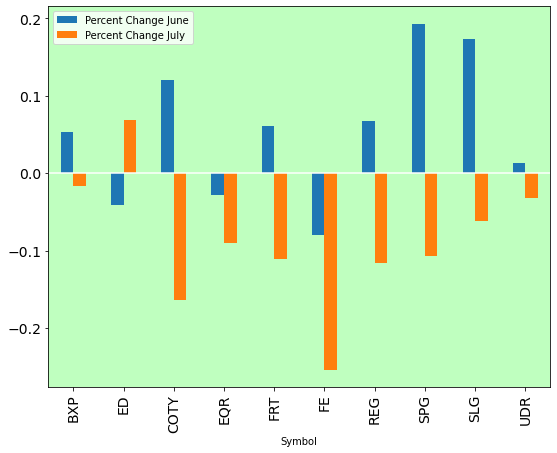

In [45]:
# Barplot for the difference from June to July
axis = Tickers_Failedto_Recover.plot(x ="Symbol", y=["Percent Change June" ,"Percent Change July"], kind = 'bar', fontsize =14, figsize=(9, 7))
axis.axhline(color='w')
axis.set_facecolor((0, 1, 0, 0.25))

# Research Question 4

For this section, our goal is to compare sentiment based signals to traditional stock indicators and see how well they agree or disagree at the company level. The traditional indicator we will use is MACD (moving average convergence-divergence). Sentiment will be based on article descriptions or abstracts sourced from NYT and Contextual Web Search. The actual sentiment will be computed via a rule based algorithm known as Vader which will provide text proportions that are positive, negative or neutral (`vader_pos`, `vader_neu`, `vader_neg`) and a compound score (`vader_compound`) representing the overall strength of the positive or negative sentiment of the input text. We will narrow our analysis down to just the month of August. 

We begin our analysis by building up a database of headlines for every S&P500 symbol. Note that some symbols may not have any recent news, these will be ignored. 

In [46]:
def parse_headlines(headlines, source):
    dfs = []
    for record in headlines:
        security = list(record.keys())[0]
        headlines = record[security]['headline']
        pub_dates = record[security]['pub_date']
        security_headline_data = {
            'Security': len(pub_dates) * [security],
            'headline': headlines,
            'pub_date': pub_dates,
            'Source': len(pub_dates) * [source]
        }
        dfs.append(pd.DataFrame(security_headline_data))
    return pd.concat(dfs, axis='rows', ignore_index=True)

In [47]:
# reload in case files were modified

ticker_info_path = os.path.normpath('data/sp500_ticker_info.csv')
ticker_price_path = os.path.normpath('data/sp500_ticker_prices.csv')

ticker_info_df = pd.read_csv(ticker_info_path)
ticker_price_df = pd.read_csv(ticker_price_path)

In [48]:
# pull data in using api module

from utils.api import fetch_headlines_contextual, fetch_headlines_nyt

start_date = '20200801'
end_date = '20200831'

headline_path = os.path.normpath('data/sp500_headlines.csv')

if not (os.path.isfile(headline_path) and os.access(headline_path, os.R_OK)):
    securities = ticker_info_df['Security'].unique()
    contextual_headlines = fetch_headlines_contextual(securities, start_date=start_date, end_date=end_date)
    contextual_headlines_df = parse_headlines(contextual_headlines, source='Contextual Web News')
    contextual_headlines_df.to_csv(os.path.normpath('data/sp500_contextual_headlines.csv'), index=False)
    
    nyt_headlines = fetch_headlines_nyt(securities, start_date=start_date, end_date=end_date)
    nyt_headlines_df = parse_headlines(nyt_headlines, source='New York Time')
    nyt_headlines_df.to_csv(os.path.normpath('data/sp500_nyt_headlines.csv'), index=False)
    
    headline_df = pd.concat([nyt_headlines_df, contextual_headlines_df], axis='rows', ignore_index=True)
    headline_df = headline_df.sort_values(by=['Security', 'Source']).reset_index(drop=True)
    headline_df.to_csv(headline_path, index=False)
    del nyt_headlines, contextual_headlines
else:
    headline_df = pd.read_csv(headline_path)

In [49]:
headline_df.head()

,Security,headline,pub_date,Source
0,3M Company,<b><b>3M Company's</b></b> (MMM) Q2 results ar...,2020-08-28T06:00:13,Contextual Web News
1,3M Company,A dividend is removed today from <b><b>3M Comp...,2020-08-21T04:00:00,Contextual Web News
2,3M Company,"Pune, Maharashtra, India, August 20 2020 (Wire...",2020-08-20T08:06:56,Contextual Web News
3,3M Company,FinancialContent fully hosted finance channel,2020-08-21T00:00:00,Contextual Web News
4,3M Company,"62,000 - 72,000 + <b>Company</b> Car or Allowa...",2020-08-20T15:56:00,Contextual Web News


In [50]:
def parse_time(x):
    try:
        x = x.split('T')[0]
        x = pd.to_datetime(x, format='%Y-%m-%d')
    except pd.errors.OutOfBoundsDatetime:
        x = None
    return x

In [51]:
import re

def filter_headline(x):
    try:
        x = re.sub(r'<[A-z\/]+>', '', x)
        x = re.sub(r'[\n]+', '', x)
    except TypeError:
        x = None
    return x

In [52]:
# clean up dates and headlines

headline_df['headline'] = headline_df['headline'].map(filter_headline)
headline_df['pub_date'] = headline_df['pub_date'].map(parse_time)

headline_df.dropna(axis='rows', inplace=True)

headline_df.head()

,Security,headline,pub_date,Source
0,3M Company,3M Company's (MMM) Q2 results are expected to ...,2020-08-28,Contextual Web News
1,3M Company,A dividend is removed today from 3M Company's ...,2020-08-21,Contextual Web News
2,3M Company,"Pune, Maharashtra, India, August 20 2020 (Wire...",2020-08-20,Contextual Web News
3,3M Company,FinancialContent fully hosted finance channel,2020-08-21,Contextual Web News
4,3M Company,"62,000 - 72,000 + Company Car or Allowance & P...",2020-08-20,Contextual Web News


In [53]:
headline_df['Source'].value_counts()

Contextual Web News    33386
New York Time           1726
Name: Source, dtype: int64

In [54]:
headline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35112 entries, 0 to 35113
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Security  35112 non-null  object        
 1   headline  35112 non-null  object        
 2   pub_date  35112 non-null  datetime64[ns]
 3   Source    35112 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.3+ MB


In [55]:
from utils.api import compute_headline_sentiment

headline_df = compute_headline_sentiment(headline_df)
headline_df.head(10)

35112it [00:52, 672.65it/s]


,Security,headline,pub_date,Source,vader_neg,vader_neu,vader_pos,vader_compound
0,3M Company,3M Company's (MMM) Q2 results are expected to ...,2020-08-28,Contextual Web News,0.135,0.720,0.144,0.0772
1,3M Company,A dividend is removed today from 3M Company's ...,2020-08-21,Contextual Web News,0.000,0.761,0.239,0.2960
2,3M Company,"Pune, Maharashtra, India, August 20 2020 (Wire...",2020-08-20,Contextual Web News,0.000,1.000,0.000,0.0000
3,3M Company,FinancialContent fully hosted finance channel,2020-08-21,Contextual Web News,0.000,1.000,0.000,0.0000
4,3M Company,"62,000 - 72,000 + Company Car or Allowance & P...",2020-08-20,Contextual Web News,0.000,0.917,0.083,0.4019
5,3M Company,"New Haven, CT (PRWEB) August 31, 2020 -- Bond...",2020-08-31,Contextual Web News,0.000,0.884,0.116,0.4404
6,3M Company,"SAN FRANCISCO and SUZHOU, China, Aug. 30, 2020...",2020-08-31,Contextual Web News,0.000,1.000,0.000,0.0000
7,3M Company,oOh!media Limited (ASX: OML) (oOh! or Company)...,2020-08-30,Contextual Web News,0.065,0.817,0.119,0.3786
8,3M Company,"According to the sources, cited by the platfor...",2020-08-30,Contextual Web News,0.000,1.000,0.000,0.0000
9,3M Company,A New Plymouth home improvement company has de...,2020-08-30,Contextual Web News,0.000,0.769,0.231,0.4588


Let's see the overall breakdown of compound scores, with and without grouping by the GICS Sector.

Text(0, 0.5, 'vader_compound score')

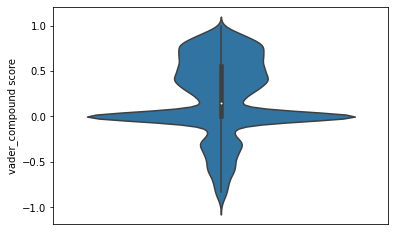

In [56]:
import seaborn as sns

ax = sns.violinplot(data=headline_df['vader_compound'])
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('vader_compound score')

It looks like most compound scores end up being close purely neutral (i.e. close to 0) with a good amount showing positive scores. Negative scores are the least prevalent. Let's classify every headline based on the vader class proportions (`vader_pos`, `vader_neu`, `vader_neg`) and call it `vader_class`. 

In [57]:
def classify_sentiment(dataframe):
    sentiment_classes = np.array(['pos', 'neu', 'neg'])
    sentiment_ids = dataframe[['vader_pos', 'vader_neu', 'vader_neg']].to_numpy().argmax(axis=1)
    dataframe['vader_class'] = sentiment_classes.take(sentiment_ids)
    return dataframe

In [58]:
headline_df = classify_sentiment(headline_df)
headline_df = pd.merge(headline_df, ticker_info_df[['Security', 'GICS Sector', 'Symbol']], on='Security')
headline_df.head(10)

,Security,headline,pub_date,Source,vader_neg,vader_neu,vader_pos,vader_compound,vader_class,GICS Sector,Symbol
0,3M Company,3M Company's (MMM) Q2 results are expected to ...,2020-08-28,Contextual Web News,0.135,0.720,0.144,0.0772,neu,Industrials,MMM
1,3M Company,A dividend is removed today from 3M Company's ...,2020-08-21,Contextual Web News,0.000,0.761,0.239,0.2960,neu,Industrials,MMM
2,3M Company,"Pune, Maharashtra, India, August 20 2020 (Wire...",2020-08-20,Contextual Web News,0.000,1.000,0.000,0.0000,neu,Industrials,MMM
3,3M Company,FinancialContent fully hosted finance channel,2020-08-21,Contextual Web News,0.000,1.000,0.000,0.0000,neu,Industrials,MMM
4,3M Company,"62,000 - 72,000 + Company Car or Allowance & P...",2020-08-20,Contextual Web News,0.000,0.917,0.083,0.4019,neu,Industrials,MMM
5,3M Company,"New Haven, CT (PRWEB) August 31, 2020 -- Bond...",2020-08-31,Contextual Web News,0.000,0.884,0.116,0.4404,neu,Industrials,MMM
6,3M Company,"SAN FRANCISCO and SUZHOU, China, Aug. 30, 2020...",2020-08-31,Contextual Web News,0.000,1.000,0.000,0.0000,neu,Industrials,MMM
7,3M Company,oOh!media Limited (ASX: OML) (oOh! or Company)...,2020-08-30,Contextual Web News,0.065,0.817,0.119,0.3786,neu,Industrials,MMM
8,3M Company,"According to the sources, cited by the platfor...",2020-08-30,Contextual Web News,0.000,1.000,0.000,0.0000,neu,Industrials,MMM
9,3M Company,A New Plymouth home improvement company has de...,2020-08-30,Contextual Web News,0.000,0.769,0.231,0.4588,neu,Industrials,MMM


In [59]:
headline_df['vader_class'].value_counts()

neu    35002
pos       86
neg       24
Name: vader_class, dtype: int64

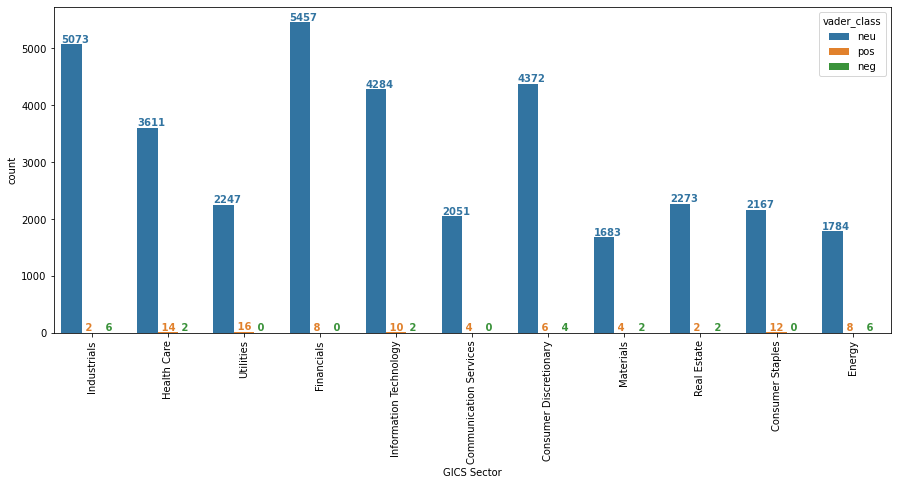

In [60]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.countplot(x='GICS Sector', hue='vader_class', data=headline_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

for rect in ax.patches:
    height = rect.get_height()
    try:
        height = int(height)
    except ValueError:
        height = 0
    ax.annotate(text=f'{height:^4}',
                xy=(rect.get_x(), height),
                ha='left',
                va='bottom',
                color=rect.get_facecolor(),
                fontweight='bold')

Clearly, nearly all headlines have a majority a of neutral text.

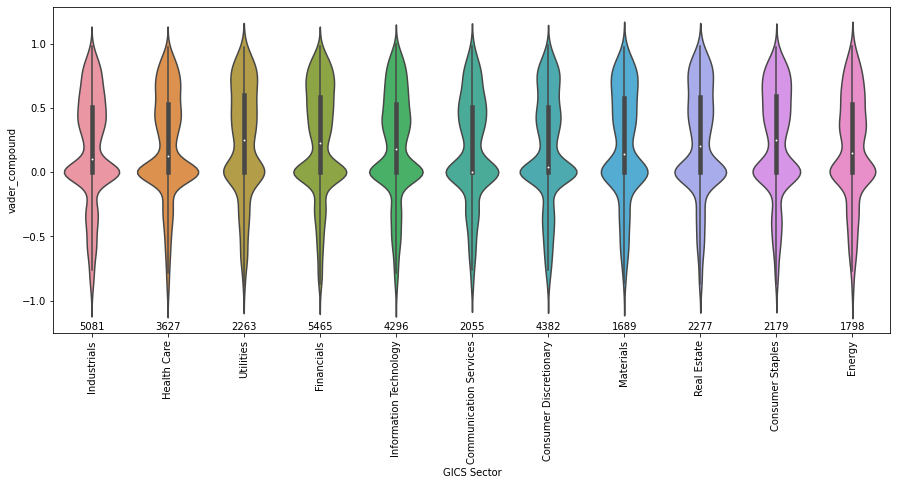

In [61]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.violinplot(x='GICS Sector', y='vader_compound', data=headline_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

sector_counts = headline_df.groupby('GICS Sector')[['headline']].count().to_dict()['headline']

for i, label in enumerate(ax.get_xticklabels()):
    count = sector_counts[label.get_text()]
    ax.annotate(text=f'{count}', xy=(i, -1.2), ha='center', va='center')

Interestingly, the distribution shapes are roughly the same across every GICS sector. This could perhaps be due to an inadequacy of vader in interpreting news headlines and tending everything toward neutral or a greater likelihood of publishing neutral or positive news. So far, it looks like headlines tend to be neutral/positive over negative. 

In [62]:
headline_df.groupby('GICS Sector')[['vader_compound']].agg(['mean', 'median', 'std', 'min', 'max'])

vader_compound                                   
                                 mean   median       std     min     max
GICS Sector                                                             
Communication Services       0.173439  0.00000  0.407467 -0.9100  0.9804
Consumer Discretionary       0.172273  0.03870  0.425014 -0.9359  0.9865
Consumer Staples             0.232506  0.25000  0.417923 -0.9113  0.9766
Energy                       0.181387  0.14535  0.414102 -0.9517  0.9847
Financials                   0.228664  0.22630  0.424630 -0.9517  0.9799
Health Care                  0.206921  0.12800  0.402046 -0.9732  0.9766
Industrials                  0.172068  0.10270  0.424029 -0.9690  0.9786
Information Technology       0.202723  0.17790  0.413744 -0.9686  0.9934
Materials                    0.207865  0.14070  0.428196 -0.9206  0.9766
Real Estate                  0.229369  0.20230  0.422488 -0.9136  0.9801
Utilities                    0.230732  0.25000  0.430602 -0.9136  0.9766

If we reduce our data to key summary statistics, we can see some interesting trends. Real Estate, Consumer Staples, Financials and Utilities lead the pack in overall positive sentiment based on mean/median. Another very interesting observation is the discrepancy in mean and median for Consumer Discretionary. The mean is significantly higher then the median suggesting positive outliers in the the compound scores.

Let's also see what some examples of extreme scoring headlines look like. 

In [63]:
def show_extreme_headlines(dataframe, by='GICS Sector'):
    cats = dataframe[by].unique()
    extremes = []
    for cat in cats:
        idx = dataframe[by] == cat
        sub_df = dataframe.loc[idx].sort_values(by='vader_compound')
        min_ = sub_df.iloc[0:1]
        max_ = sub_df.iloc[-2:-1]
        extremes.append(pd.concat([min_, max_], axis='rows'))
    return pd.concat(extremes, axis='rows', ignore_index=True)

In [64]:
pd.set_option('display.max_colwidth', 0)

show_extreme_headlines(headline_df)[['Security',
                                     'GICS Sector', 
                                     'headline', 
                                     'vader_compound', 
                                     'vader_pos',
                                     'vader_neu',
                                     'vader_neg',
                                     'vader_class']]

,Security,GICS Sector,headline,vader_compound,vader_pos,vader_neu,vader_neg,vader_class
0,Norfolk Southern Corp.,Industrials,"Gunmen blocked a group of motorcycle riders then opened fire with assault rifles in a busy downtown area in the southern Philippines, killing nine people, police said Sunday, in the latest violence to roil the volatile region. Police officials said the attack on the victims, who were mostly farmers, at",-0.9690,0.000,0.649,0.351,neu
1,Howmet Aerospace,Industrials,"ABW FILE PHOTOTHE PHILIPPINES and the UK plan to strengthen their economic partnership to increase investments in key sectors like aerospace and electronics.The two countries, represented by the Trade department and British Ambassador to the Philippines Daniel Pruce, on Aug. 19 held their first economic dialogue since the start of the lockdowns declared to contain the pandemic, the Department of Trade and Industry (DTI) said in a statement Thursday.Both countries reaffirm their commitment through a Joint Partnership Statement that will boost bilateral trade and investment (and) encourage increased investments in key sectors such as aerospace, electronics, automotive and pharmaceuticals; pursue innovation and industrial collaboration, the DTI said.The DTI also said that the partnership will support the development of micro, small, and medium-sized enterprises and support the use of the UK Prosperity Fund in areas like health, education, low-carbon energy, infrastructure, finance, b",0.9786,0.193,0.807,0.000,neu
2,Gilead Sciences,Health Care,"On Tuesday, a judge denied the request of convicted child rapist Roman Polanski to be reinstated to the Academy of Motion Picture Arts and Sciences, ruling that the academy had a right to expel him in 2018. Polanski sued the Academy in April 2019, claiming that he had been thrown out without any warning and without a fair process. Honestly, Im genuinely stunned that this awful predator, who has been accused of rape by at least six women (most recently in 2019), had the audacity to sue the Academy for kicking him out decades after they should have.",-0.9732,0.018,0.749,0.233,neu
3,Baxter International Inc.,Health Care,GMR led Hyderabad International Airport has won the prestigious awards of National Energy Leader and Excellent Energy Efficient Unit at the 21st National Awards for Excellence in Energy Management o,0.9766,0.571,0.429,0.000,pos
4,American Water Works Company Inc,Utilities,"BOSEMAN PASSES (viaAP)Absolutely devastating news from Hollywood: Chadwick Boseman, who played Black American icons Jackie Robinson and James Brown with searing intensity before inspiring audiences worldwide as the regalBlack PantherinMarvelsblockbuster movie franchise, died Friday of cancer. He was 43. Boseman died at his home in the Los Angeles area with his wife and family by []",-0.9136,0.073,0.703,0.224,neu
5,NRG Energy,Utilities,GMR led Hyderabad International Airport has won the prestigious awards of National Energy Leader and Excellent Energy Efficient Unit at the 21st National Awards for Excellence in Energy Management o,0.9766,0.571,0.429,0.000,pos
6,Lincoln National,Financials,"MINNEAPOLIS (AP) "" An emergency curfew expired and downtown Minneapolis was calm Thursday morning after unrest broke out following what authorities said was misinformation about the suicide of a Black homicide suspect. Gov. Tim Walz mobilized the Minnesota National Guard at the request of Mayor Jacob Frey, who imposed the curfew after people broke windows and stole merchandise Wednesday night from stores on and near the Nicollet Mall, a pedestrian plaza that runs through downtown. People broke",-0.9517,0.026,0.734,0.240,neu
7,The Travelers Companies Inc.,Financials,"The Peninsula Crowne Plaza Doha West Bay has announced that it has recently won the 2020 Travelers' Choice Best of the Best award, based on a full year of TripAdvisor's reviews, ratings and travel saves. Award winners exemplify traveler's ultimate favorite, and are considered am

These aren't super relevant, but it is clear that the sentiment scores reflect the overall connotation. Perhaps we aren't able to fetch enough actually relevant news in the past month for each of the 500 securities we are looking for. This is one downside of limiting our analysis time window.

Before shifting to traditional stock signals, let's aggregate the headline sentiment info for each company and see what insights we can make. We will need company based sentiment scores to compare to the traditional signals later on.

In [65]:
def aggregate_sentiment(dataframe, by='Security'):
    sentiment_categories = np.array(['pos', 'neu', 'neg'])
    categories = dataframe[by].unique()
    agg_sentiments = []
    for cat in categories:
        idx = dataframe[by] == cat
        sub_df = dataframe.loc[idx]
        sentiment_category_sum = np.sum(sub_df[['vader_pos', 'vader_neu', 'vader_neg']].to_numpy(), axis=0)
        sentiment_category_sum = sentiment_category_sum / (sentiment_category_sum.sum())  # renormalize
        sentiment_id = sentiment_categories.take(sentiment_category_sum.argmax())
        sentiment_compound_mean = sub_df['vader_compound'].mean()
        record = {
            by: cat,
            'vader_pos': sentiment_category_sum[0],
            'vader_neu': sentiment_category_sum[1],
            'vader_neg': sentiment_category_sum[2],
            'vader_class': sentiment_id,
            'vader_compound': sentiment_compound_mean
        }
        agg_sentiments.append(record)
    return pd.DataFrame(agg_sentiments)

In [66]:
security_sent_df = aggregate_sentiment(headline_df, by='Security')
sector_sent_df = aggregate_sentiment(headline_df, by='GICS Sector')

In [67]:
security_sent_df.head()

,Security,vader_pos,vader_neu,vader_neg,vader_class,vader_compound
0,3M Company,0.082878,0.876282,0.040839,neu,0.160962
1,A.O. Smith Corp,0.053805,0.882857,0.063339,neu,-0.024227
2,ABIOMED Inc,0.156333,0.843667,0.000000,neu,0.630967
3,AES Corp,0.061659,0.914162,0.024180,neu,0.147656
4,AFLAC Inc,0.111611,0.877488,0.010901,neu,0.425350


In [68]:
security_sent_df['vader_class'].value_counts()

neu    496
Name: vader_class, dtype: int64

Text(0.5, 1.0, 'mean vader_compound scores for each security')

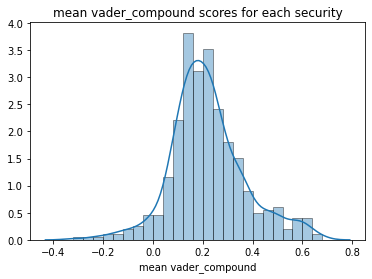

In [69]:
ax = sns.distplot(a=security_sent_df['vader_compound'], hist=True, hist_kws={'edgecolor': 'k'})
ax.set_xlabel('mean vader_compound')
ax.set_title('mean vader_compound scores for each security')

We can see that after aggregation, the sentiment ratio is only classified as neutral at the company level. As a result of this, I will focus my remaining analysis on the compound scores and binarize outcomes as positive or negative only for simplicity. Furthermore, the compound scores from Vader tend to be overwhelmingly neutral/slightly positive. This is likely a combination of the weakness of the algorithm for the given task and a lack of strongly biased news articles from the source that I am using. Note that when aggregating the ratios, we simply sum and renormalize the ratios for each company, thus no word counts are used.

Now, let's shift our focus to how we can use traditional stock indicators to indicate a buy/sell. For this analysis, we will use Moving Average Convergence Divergence, or $MACD$. In particular, we will use $MACD(12, 26, 9)$, which indicates that we will look at 12-day and 26-day exponential moving averages, subtract them to obtain the $MACD$ line, which we will then take a 9-day exponential moving average of to give us the signal line. When the $MACD$ line and signal line crossover, it signals a positive or negative event.

Let's analyze this for one stock, GOOGL, as an illustrative example.

In [70]:
from utils.stock_signals import candlestick, macd, macd_indicators

stock = 'GOOGL'
idx = ticker_price_df['Symbol'] == stock
googl_data = ticker_price_df.loc[idx]
googl_data = pd.concat([googl_data, macd(googl_data['Close'])], axis='columns')
googl_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Close EMA 12,Close EMA 26,Close MACD,Close MACD Signal
3652,2020-01-02,1348.410034,1368.680054,1346.489990,1368.680054,1368.680054,1363900.0,GOOGL,NaN,NaN,NaN,NaN
3653,2020-01-03,1348.000000,1373.750000,1347.319946,1361.520020,1361.520020,1170400.0,GOOGL,NaN,NaN,NaN,NaN
3654,2020-01-06,1351.630005,1398.319946,1351.000000,1397.810059,1397.810059,2338400.0,GOOGL,NaN,NaN,NaN,NaN
3655,2020-01-07,1400.459961,1403.500000,1391.560059,1395.109985,1395.109985,1716500.0,GOOGL,NaN,NaN,NaN,NaN
3656,2020-01-08,1394.819946,1411.849976,1392.630005,1405.040039,1405.040039,1765700.0,GOOGL,NaN,NaN,NaN,NaN


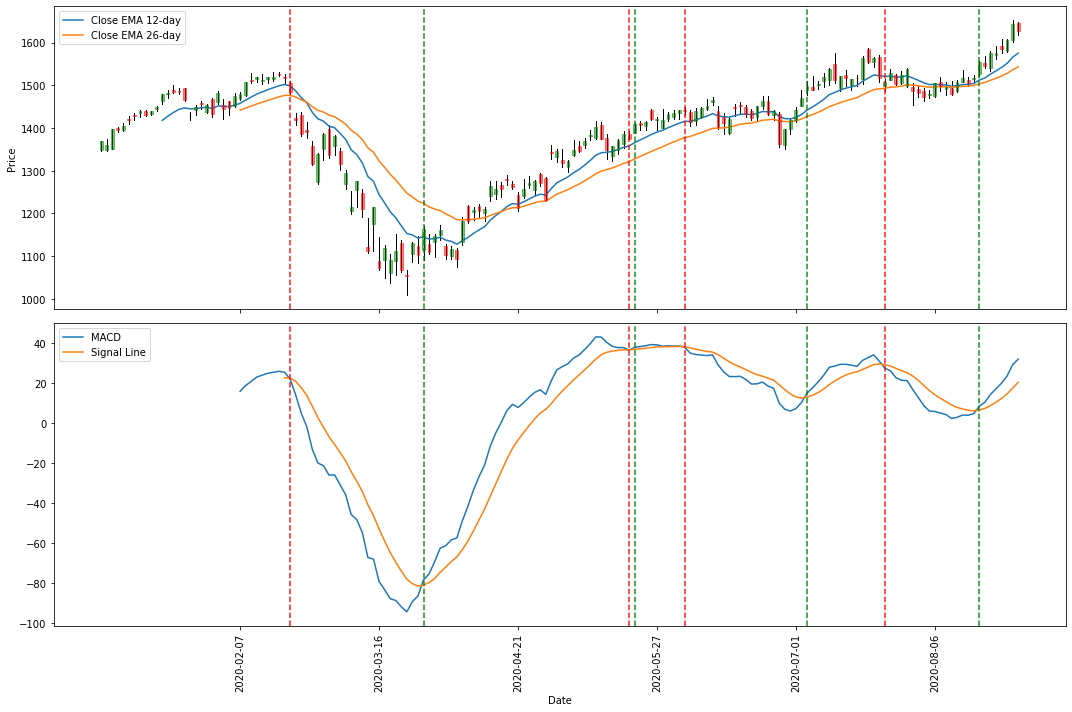

In [71]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=2)

dates = googl_data['Date'].to_numpy()
xticks = np.arange(25, 175, 25)

ax[0] = candlestick(ax[0], googl_data)
ax[0].plot(googl_data['Close EMA 12'].to_numpy(), label='Close EMA 12-day')
ax[0].plot(googl_data['Close EMA 26'].to_numpy(), label='Close EMA 26-day')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Price')
ax[0].legend()
xlim = ax[0].get_xlim()

ax[1].plot(googl_data['Close MACD'].to_numpy(), label='MACD')
ax[1].plot(googl_data['Close MACD Signal'].to_numpy(), label='Signal Line')
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(dates[xticks], rotation=90)
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].set_xlim(xlim)

googl_data = macd_indicators(googl_data)
idx = googl_data['Close MACD Signal Line Crossover'].to_numpy() != 0
events = zip(np.arange(len(googl_data))[idx], googl_data['Close MACD Signal Line Crossover'].to_numpy()[idx])

for event in events:
    if event[1] > 0:
        color = 'r'
    else:
        color = 'g'
    ax[0].axvline(x=event[0], color=color, linestyle='--', alpha=0.9)
    ax[1].axvline(x=event[0], color=color, linestyle='--', alpha=0.9)

plt.tight_layout()

Notice the $MACD$ line and the signal line have several crossover points. When the signal line travels under the $MACD$ line, it is considered a bullish sign, whereas when it travels over the $MACD$ line it is considered a bearish sign. We are able to find these crossover points automatically. We code a bullish crossover as -1 and a bearish crossover as +1 in the dataframe. In the preceding plots, these crossover events are marked as green vertical lines for bullish and red vertical lines for bearish. Now, let's compute the signals for every ticker in our database.

In [72]:
def compute_all_signals(dataframe):
    symbols = dataframe['Symbol'].unique()
    signal_dfs = []
    for symbol in symbols:
        idx = dataframe['Symbol'] == symbol
        symbol_df = dataframe.loc[idx]
        macd_df = pd.concat([symbol_df, macd(symbol_df['Close'])], axis='columns')
        signal_df = macd_indicators(macd_df)
        signal_dfs.append(signal_df)
    return pd.concat(signal_dfs, axis='rows')

In [73]:
ticker_price_df.dropna(axis='rows', inplace=True)
signal_df = compute_all_signals(ticker_price_df)
signal_df['Date'] = pd.to_datetime(signal_df['Date'], format='%Y-%m-%d')
signal_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Close EMA 12,Close EMA 26,Close MACD,Close MACD Signal,Close MACD Zero Crossover,Close MACD Signal Line Crossover
0,2020-01-02,177.679993,180.009995,177.139999,180.000000,175.039474,3601700.0,MMM,NaN,NaN,NaN,NaN,0,0
1,2020-01-03,177.020004,178.660004,175.630005,178.449997,173.532181,2466900.0,MMM,NaN,NaN,NaN,NaN,0,0
2,2020-01-06,177.149994,178.710007,176.350006,178.619995,173.697495,1998000.0,MMM,NaN,NaN,NaN,NaN,0,0
3,2020-01-07,178.279999,178.509995,176.820007,177.899994,172.997330,2173000.0,MMM,NaN,NaN,NaN,NaN,0,0
4,2020-01-08,178.000000,181.500000,177.649994,180.630005,175.652115,2758300.0,MMM,NaN,NaN,NaN,NaN,0,0


In [74]:
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83689 entries, 0 to 83699
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              83689 non-null  datetime64[ns]
 1   Open                              83689 non-null  float64       
 2   High                              83689 non-null  float64       
 3   Low                               83689 non-null  float64       
 4   Close                             83689 non-null  float64       
 5   Adj Close                         83689 non-null  float64       
 6   Volume                            83689 non-null  float64       
 7   Symbol                            83689 non-null  object        
 8   Close EMA 12                      78134 non-null  float64       
 9   Close EMA 26                      71064 non-null  float64       
 10  Close MACD                        71064 non-nu

Now that we have the signal information for all stocks, let's narrow our range to the month of August to align with our sentiment data.

In [75]:
start_date = pd.to_datetime('2020-08-01', format='%Y-%m-%d')
end_date =  pd.to_datetime('2020-08-31', format='%Y-%m-%d')

idx = (signal_df['Date'] >= start_date) & (signal_df['Date'] <= end_date)
signal_df = signal_df.loc[idx].reset_index(drop=True)
signal_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Close EMA 12,Close EMA 26,Close MACD,Close MACD Signal,Close MACD Zero Crossover,Close MACD Signal Line Crossover
0,2020-08-03,151.089996,151.419998,149.309998,150.410004,149.053299,2264900.0,MMM,155.194297,155.977587,-0.783290,0.222555,0,0
1,2020-08-04,149.899994,151.240005,149.660004,151.210007,149.846085,1935500.0,MMM,154.581329,155.624433,-1.043104,-0.030577,0,0
2,2020-08-05,152.160004,155.399994,152.100006,155.350006,153.948730,2723400.0,MMM,154.699587,155.604105,-0.904518,-0.205365,0,0
3,2020-08-06,155.929993,156.490005,154.679993,156.000000,154.592865,2885800.0,MMM,154.899651,155.633430,-0.733780,-0.311048,0,0
4,2020-08-07,155.990005,158.419998,155.070007,158.330002,156.901855,2184300.0,MMM,155.427397,155.833176,-0.405779,-0.329994,0,0


To summarize the $MACD$ signal crossover information for each stock symbol, we essentially count the number of bullish and bearish crossovers and determine whether we are net bullish (positive), net bearish (negative) or neither (neutral).

In [76]:
def aggregate_macd_signals(dataframe, indicator='Close MACD Signal Line Crossover'):
    sign_map = {-1: 'pos', 1: 'neg', 0: 'neu'}  # recall the macd coding
    symbols = dataframe['Symbol'].unique()
    records = []
    for symbol in symbols:
        idx = dataframe['Symbol'] == symbol
        symbol_df = dataframe.loc[idx]
        agg_signal = symbol_df[indicator].sum()
        overall_signal = sign_map[int(np.sign(agg_signal))]
        record = {
            'Symbol': symbol,
            indicator + ' Sum': overall_signal
        }
        records.append(record)
    return pd.DataFrame(records)

In [77]:
signal_df = aggregate_macd_signals(signal_df)
signal_df = pd.merge(signal_df, ticker_info_df[['Symbol', 'Security', 'GICS Sector']], on='Symbol')
signal_df = signal_df[['Symbol', 'Security', 'GICS Sector', 'Close MACD Signal Line Crossover Sum']]
signal_df.head()

,Symbol,Security,GICS Sector,Close MACD Signal Line Crossover Sum
0,MMM,3M Company,Industrials,pos
1,ABT,Abbott Laboratories,Health Care,neu
2,ABBV,AbbVie Inc.,Health Care,pos
3,ABMD,ABIOMED Inc,Health Care,neu
4,ACN,Accenture plc,Information Technology,pos


Text(0.5, 1.0, 'MACD Signal Line Crossover Indicator')

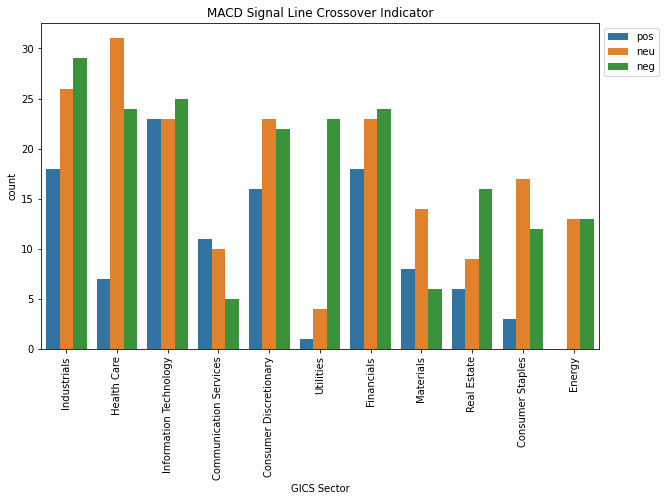

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x=signal_df['GICS Sector'], hue=signal_df['Close MACD Signal Line Crossover Sum'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=[1., 1.])
ax.set_title('MACD Signal Line Crossover Indicator')

From the preceding plot, we can see $MACD$ indicators tend to be neutral/negative for most industries with the exception of Communication Services. We can also see Utilities stocks are showing mostly bearish $MACD$ indicators.

Now, we will binarize the vader_compound scores based on their sign which will give us either positive or negative overall sentiment. For simplicity, we will drop any companies that did not have positive or negative $MACD$ indicators. This will allow us to examine the co-occurrences of positive/negative sentiment and positive/negative $MACD$ signals. 

In [79]:
def compound_to_binary(x):
    if np.sign(x) > 0:
        return 'pos'
    else:
        return 'neg'

In [80]:
# note that no vader_compounds == 0 after aggregation

comparison_df = pd.merge(signal_df, security_sent_df[['Security', 'vader_compound']])
comparison_df['vader_compound'] = comparison_df['vader_compound'].map(compound_to_binary)
keep_idx = comparison_df['Close MACD Signal Line Crossover Sum'] != 'neu'
comparison_df = comparison_df.loc[keep_idx].reset_index(drop=True)
comparison_df.head()

,Symbol,Security,GICS Sector,Close MACD Signal Line Crossover Sum,vader_compound
0,MMM,3M Company,Industrials,pos,pos
1,ABBV,AbbVie Inc.,Health Care,pos,pos
2,ACN,Accenture plc,Information Technology,pos,pos
3,ADBE,Adobe Inc.,Information Technology,pos,pos
4,AMD,Advanced Micro Devices Inc,Information Technology,neg,pos


In [81]:
# build the contingency table

contingency = pd.crosstab(comparison_df['Close MACD Signal Line Crossover Sum'], comparison_df['vader_compound'])
contingency

vader_compound,neg,pos
Close MACD Signal Line Crossover Sum,,
neg,8,185
pos,7,103


We can employ a chi squared test on this contingency table now to determine if the vader_compound polarity is independent of the MACD signal crossover polarity. I'll use a level of significance $\alpha = 0.05$.

In [82]:
from scipy.stats import chi2_contingency

p_value = chi2_contingency(contingency)[1]
print(f'p = {p_value}')

p = 0.5614214979697194


$p > \alpha$ so we accept the null hypothesis. Not surprisingly, the polarity as determined by vader_compound scores on news headlines is independent of the polarity as determined from $MACD$ crossovers. 